# Final Report

# Inference of median house prices of districts in California based on house and district characteristics

By group 4 - Tianne Lee, Sid Ahuja, William Ho, Weihao Sun

## Introduction

The housing market is dependent on several microeconomic and macroeconomic variables. Individual house prices are often reflective of the spatial and socioeconomic characteristics of the neighborhood in which the house resides (Stadelmann, 2010). While generating a regression model may be a robust technique to make estimates and inferences regarding house prices, many aspects of spatial elements need to be taken into consideration before doing so (Kelley Pace & Barry, 1997). Using a housing dataset, we want to explore which qualities and characteristics of houses within a district are best to include in a regression model, helping us understand the relationship between house prices and the determined set of input variables for the population. To create a better understanding towards the topic, we ask the following question: 

What combination of house and district qualities best estimate their relationship to the median house prices in a district and are those qualities significantly associated with the median house price of the district? 

In order to explore this question and the relation between median housing prices and different qualities of houses in a district, we will be using a [modified version of the California Housing dataset](https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv). This dataset is about houses found in given California block groups based on the 1990 census data. Each observation in the dataset corresponds to a block group, the smallest geographical unit for which the U.S. Census Bureau publishes sample data (Géron, 2017). In our project, we will use the words “block group” and “district” interchangeably.

The qualities (explanatory variables) that we would like to explore include:

|Attribute|Variable|Description|
|:---:|:---:|:---:|
|Continuous|Longitude|Longitude of the district|
|Continuous|Latitude|Latitude of the district|
|Continuous|Housing_median_age|Median housing age of the district|
|Continuous|Total_rooms|Total rooms in the district|
|Continuous|Total_bedrooms|Total bedrooms in the district|
|Continuous|Population|Total population in the district|
|Continuous|Households|Total households in the district|
|Continuous|Median_income|Median income of the district|
|Categorical|Ocean_proximity|Distance to the ocean, with categories: <br /> <1H OCEAN, INLAND, NEAR OCEAN, NEAR BAY, ISLAND|

*Table 1*

As we are using inference to understand the relationship between input and response variables, we have to specify the hypotheses and the significance level. Both are seen below.

Null Hypothesis: $H_0$: $\beta_1 = \beta_2 = ... = \beta_k = 0$ (the regression model does not fit the data better than the baseline model)<br />
Alternative Hypothesis: $H_1$: At least one $\beta_i \neq 0$ (the regression model fits the data better than the baseline model)

Significance level: We set the significance level to $\alpha$ = 0.05.

## Method and Results

In [1]:
library(tidyverse)
library(glmnet)
library(car)
library(broom)
library(leaps)
library(GGally)
library(psych)
library(cowplot)
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.4.0     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1-6

Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 'package:purrr':

    some


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: 'psych'


The following object is masked from 'package:car':

    logit


The following objects are masked from 'package:ggplot2':

    %+%, alpha




Firstly, we download the data from the web and save it to the repository. Each row represents the observations of one district; rows with missing values ("N/A") will be dropped so we don't make inferences based on incomplete information. After removing the missing values, we can then take a glimpse of the head of the dataset.

## Data Loading and Preprocessing

In [2]:
data <- read.csv("https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv")
write.csv(data,"house_data.csv", row.names = FALSE)
data <- data %>% drop_na()
head(data)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY
2,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY
3,-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY
4,-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY
5,-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY
6,-122.25,37.85,52,919,213,413,193,4.0368,269700,NEAR BAY


*Table 2*

Upon further inspection of the dataset and the source of the dataset, we learned that the median house value was capped at \\$500000, meaning that districts with median house values greater than \\$500000 were recorded as \\$500001. This means our data is censored. The black bar of points at the top of the plot below shows how the median house value is capped at \\$500000 in the dataset.

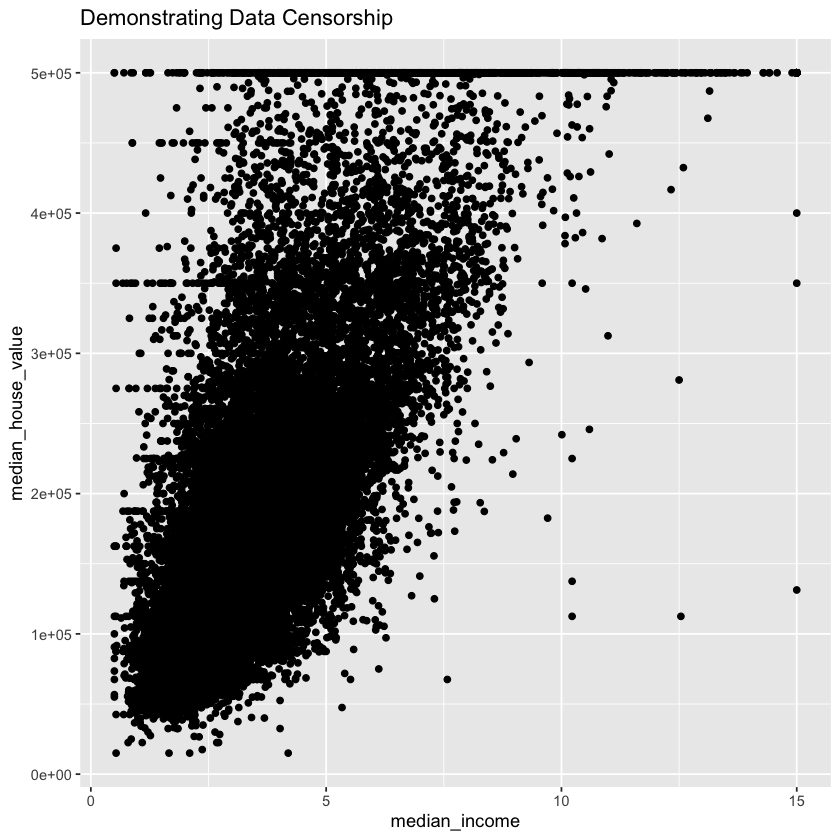

In [3]:
censor <- data %>%
    ggplot(aes(x = median_income, y = median_house_value)) +
    geom_point() +
    labs(title = "Demonstrating Data Censorship")
censor

*Figure 1*

One way of dealing with this is to use a Tobit model, but rather that trying to implement something unfamiliar to us, we will treat *`median_house_value` = 500001* observations as outliers and remove them from the data set.

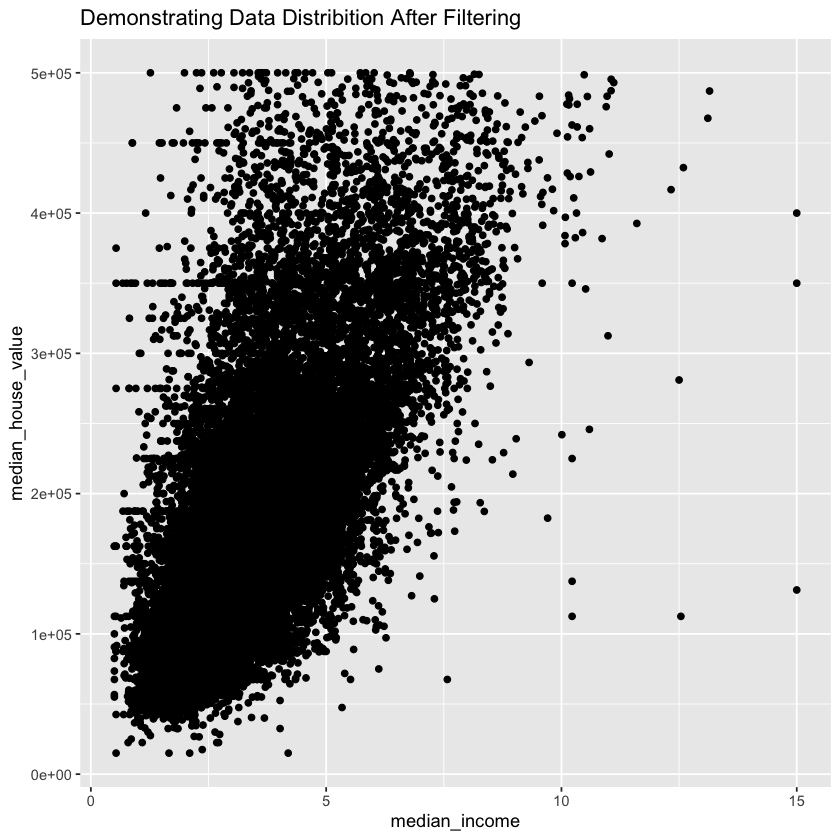

In [4]:
data <- data %>% filter(median_house_value < 500001)

censor_filtered <- data %>%
    ggplot(aes(x = median_income, y = median_house_value)) +
    geom_point() +
    labs(title = "Demonstrating Data Distribition After Filtering")
censor_filtered

*Figure 2*

There are 10 columns in the dataset, and we will treat `median_house_value` as the response variable. The data is already clean and tidy, so we can perform analysis on this dataset without concern.

As our data is focused on the median house value, it would be reasonable to convert the total numbers into averages. Using a total to make inferences regarding a median could potentially be less reliable compared to using an average. Additionally, doing this allows us to further understand the relationship between district characteristics and median house values.

In [5]:
# preprocessing from the proposal

data <- data %>% mutate(rooms_per_household = total_rooms / households,
                       bedrooms_per_household = total_bedrooms / households,
                       population_per_household = population / households)
data <- data %>% relocate(median_house_value, .after = last_col())

head(data)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_household,population_per_household,median_house_value
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,-122.23,37.88,41,880,129,322,126,8.3252,NEAR BAY,6.984127,1.0238095,2.555556,452600
2,-122.22,37.86,21,7099,1106,2401,1138,8.3014,NEAR BAY,6.238137,0.9718805,2.109842,358500
3,-122.24,37.85,52,1467,190,496,177,7.2574,NEAR BAY,8.288136,1.0734463,2.802260,352100
4,-122.25,37.85,52,1274,235,558,219,5.6431,NEAR BAY,5.817352,1.0730594,2.547945,341300
5,-122.25,37.85,52,1627,280,565,259,3.8462,NEAR BAY,6.281853,1.0810811,2.181467,342200
6,-122.25,37.85,52,919,213,413,193,4.0368,NEAR BAY,4.761658,1.1036269,2.139896,269700


*Table 3*

In [6]:
any(is.na(data))

[1] FALSE

## Preliminary Inspection

Shown below is a summary table of the dataset that shows the relevant statistics for each variable.

In [7]:
describe(data)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
longitude,1,19475,-119.564306,2.006241e+00,-118.500000,-119.512667,1.927380e+00,-124.3500000,-114.31000,10.04000,-0.28895423,-1.3239766,0.01437621
latitude,2,19475,35.653372,2.150250e+00,34.270000,35.531978,1.912554e+00,32.5400000,41.95000,9.41000,0.45519812,-1.1252586,0.01540814
housing_median_age,3,19475,28.378074,1.251537e+01,28.000000,28.219498,1.334340e+01,1.0000000,52.00000,51.00000,0.07101694,-0.7990930,0.08968195
total_rooms,4,19475,2620.491142,2.184938e+03,2111.000000,2277.739940,1.169771e+03,2.0000000,39320.00000,39318.00000,4.23887606,33.8654546,15.65670624
total_bedrooms,5,19475,539.645751,4.224132e+02,436.000000,472.932161,2.401812e+02,2.0000000,6445.00000,6443.00000,3.45735800,21.7590721,3.02690470
population,6,19475,1440.290732,1.144399e+03,1178.000000,1269.895706,6.582744e+02,3.0000000,35682.00000,35679.00000,4.98560785,74.2962441,8.20047217
households,7,19475,501.093504,3.832064e+02,411.000000,442.519864,2.223900e+02,2.0000000,6082.00000,6080.00000,3.41122730,21.8785508,2.74595894
median_income,8,19475,3.676739,1.569263e+00,3.451900,3.548219,1.498316e+00,0.4999000,15.00010,14.50020,0.91059154,1.4385851,0.01124494
ocean_proximity*,9,19475,2.149474,1.399722e+00,2.000000,1.936910,1.482600e+00,1.0000000,5.00000,4.00000,1.05331430,-0.3390402,0.01003005


*Table 4*

We create various visualizations to give a more intuitive understanding of the data. `ocean_proximity` is a categorical variable, so we generate a barplot for it. 

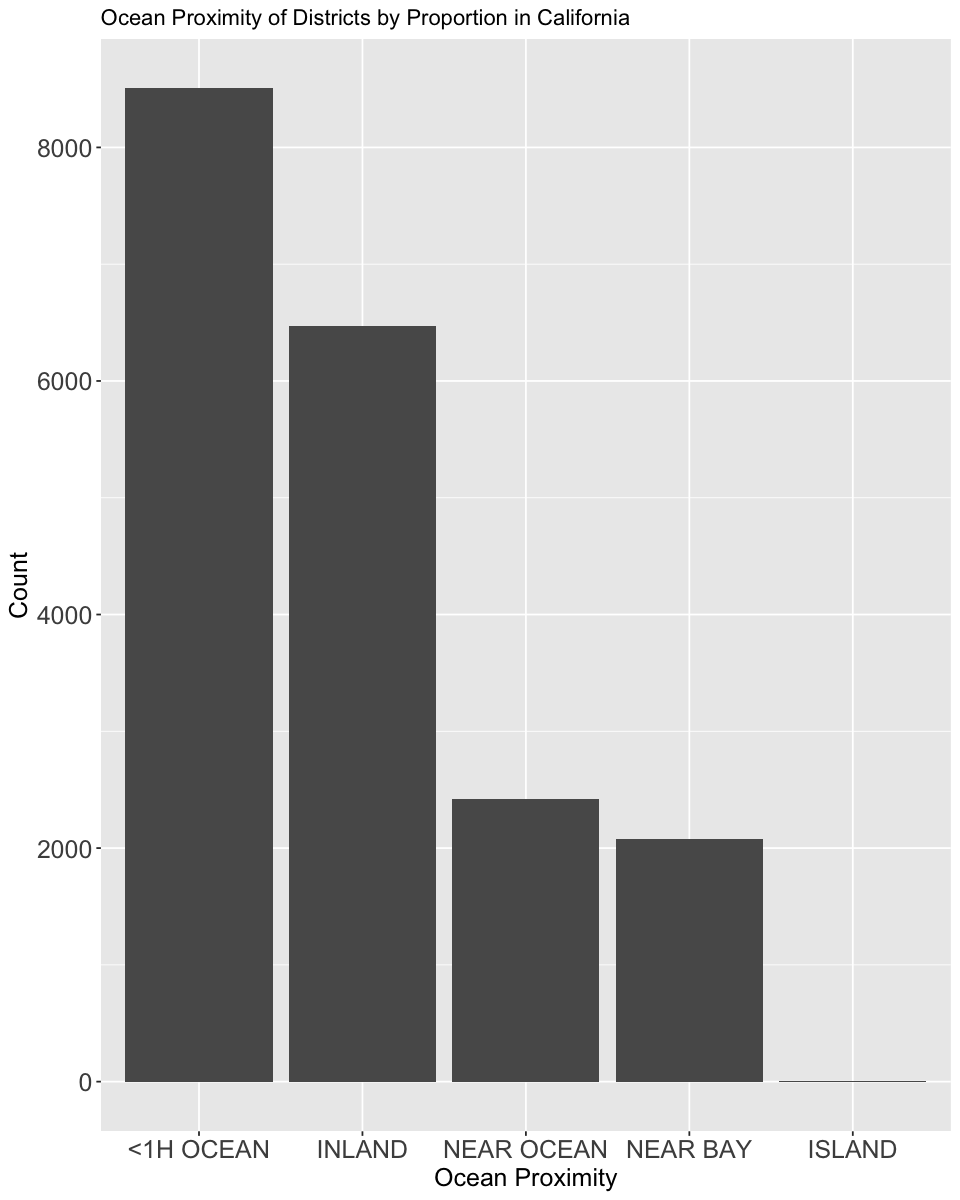

In [8]:
options(repr.plot.width=8, repr.plot.height=10)
ggplot(data, aes(x = reorder(ocean_proximity, ocean_proximity, function(x)-length(x)))) + 
    geom_bar(stat = "count") + 
    labs(title = "Ocean Proximity of Districts by Proportion in California", x = "Ocean Proximity", y = "Count") + 
    theme(axis.text = element_text(size = 15),
         axis.title.x = element_text(size = 15),
         axis.title.y = element_text(size = 15)) 

*Figure 3*

Via the barplot, the majority of people live <1 hour away from the ocean. Considering that the most populated cities (Los Angeles, San Diego, San Jose, etc.) are not far from the ocean, this would be a reasonable result.

The rest of the variables are continuous. We generate a scatter plot matrix to find possible patterns between each of them and the response variable.

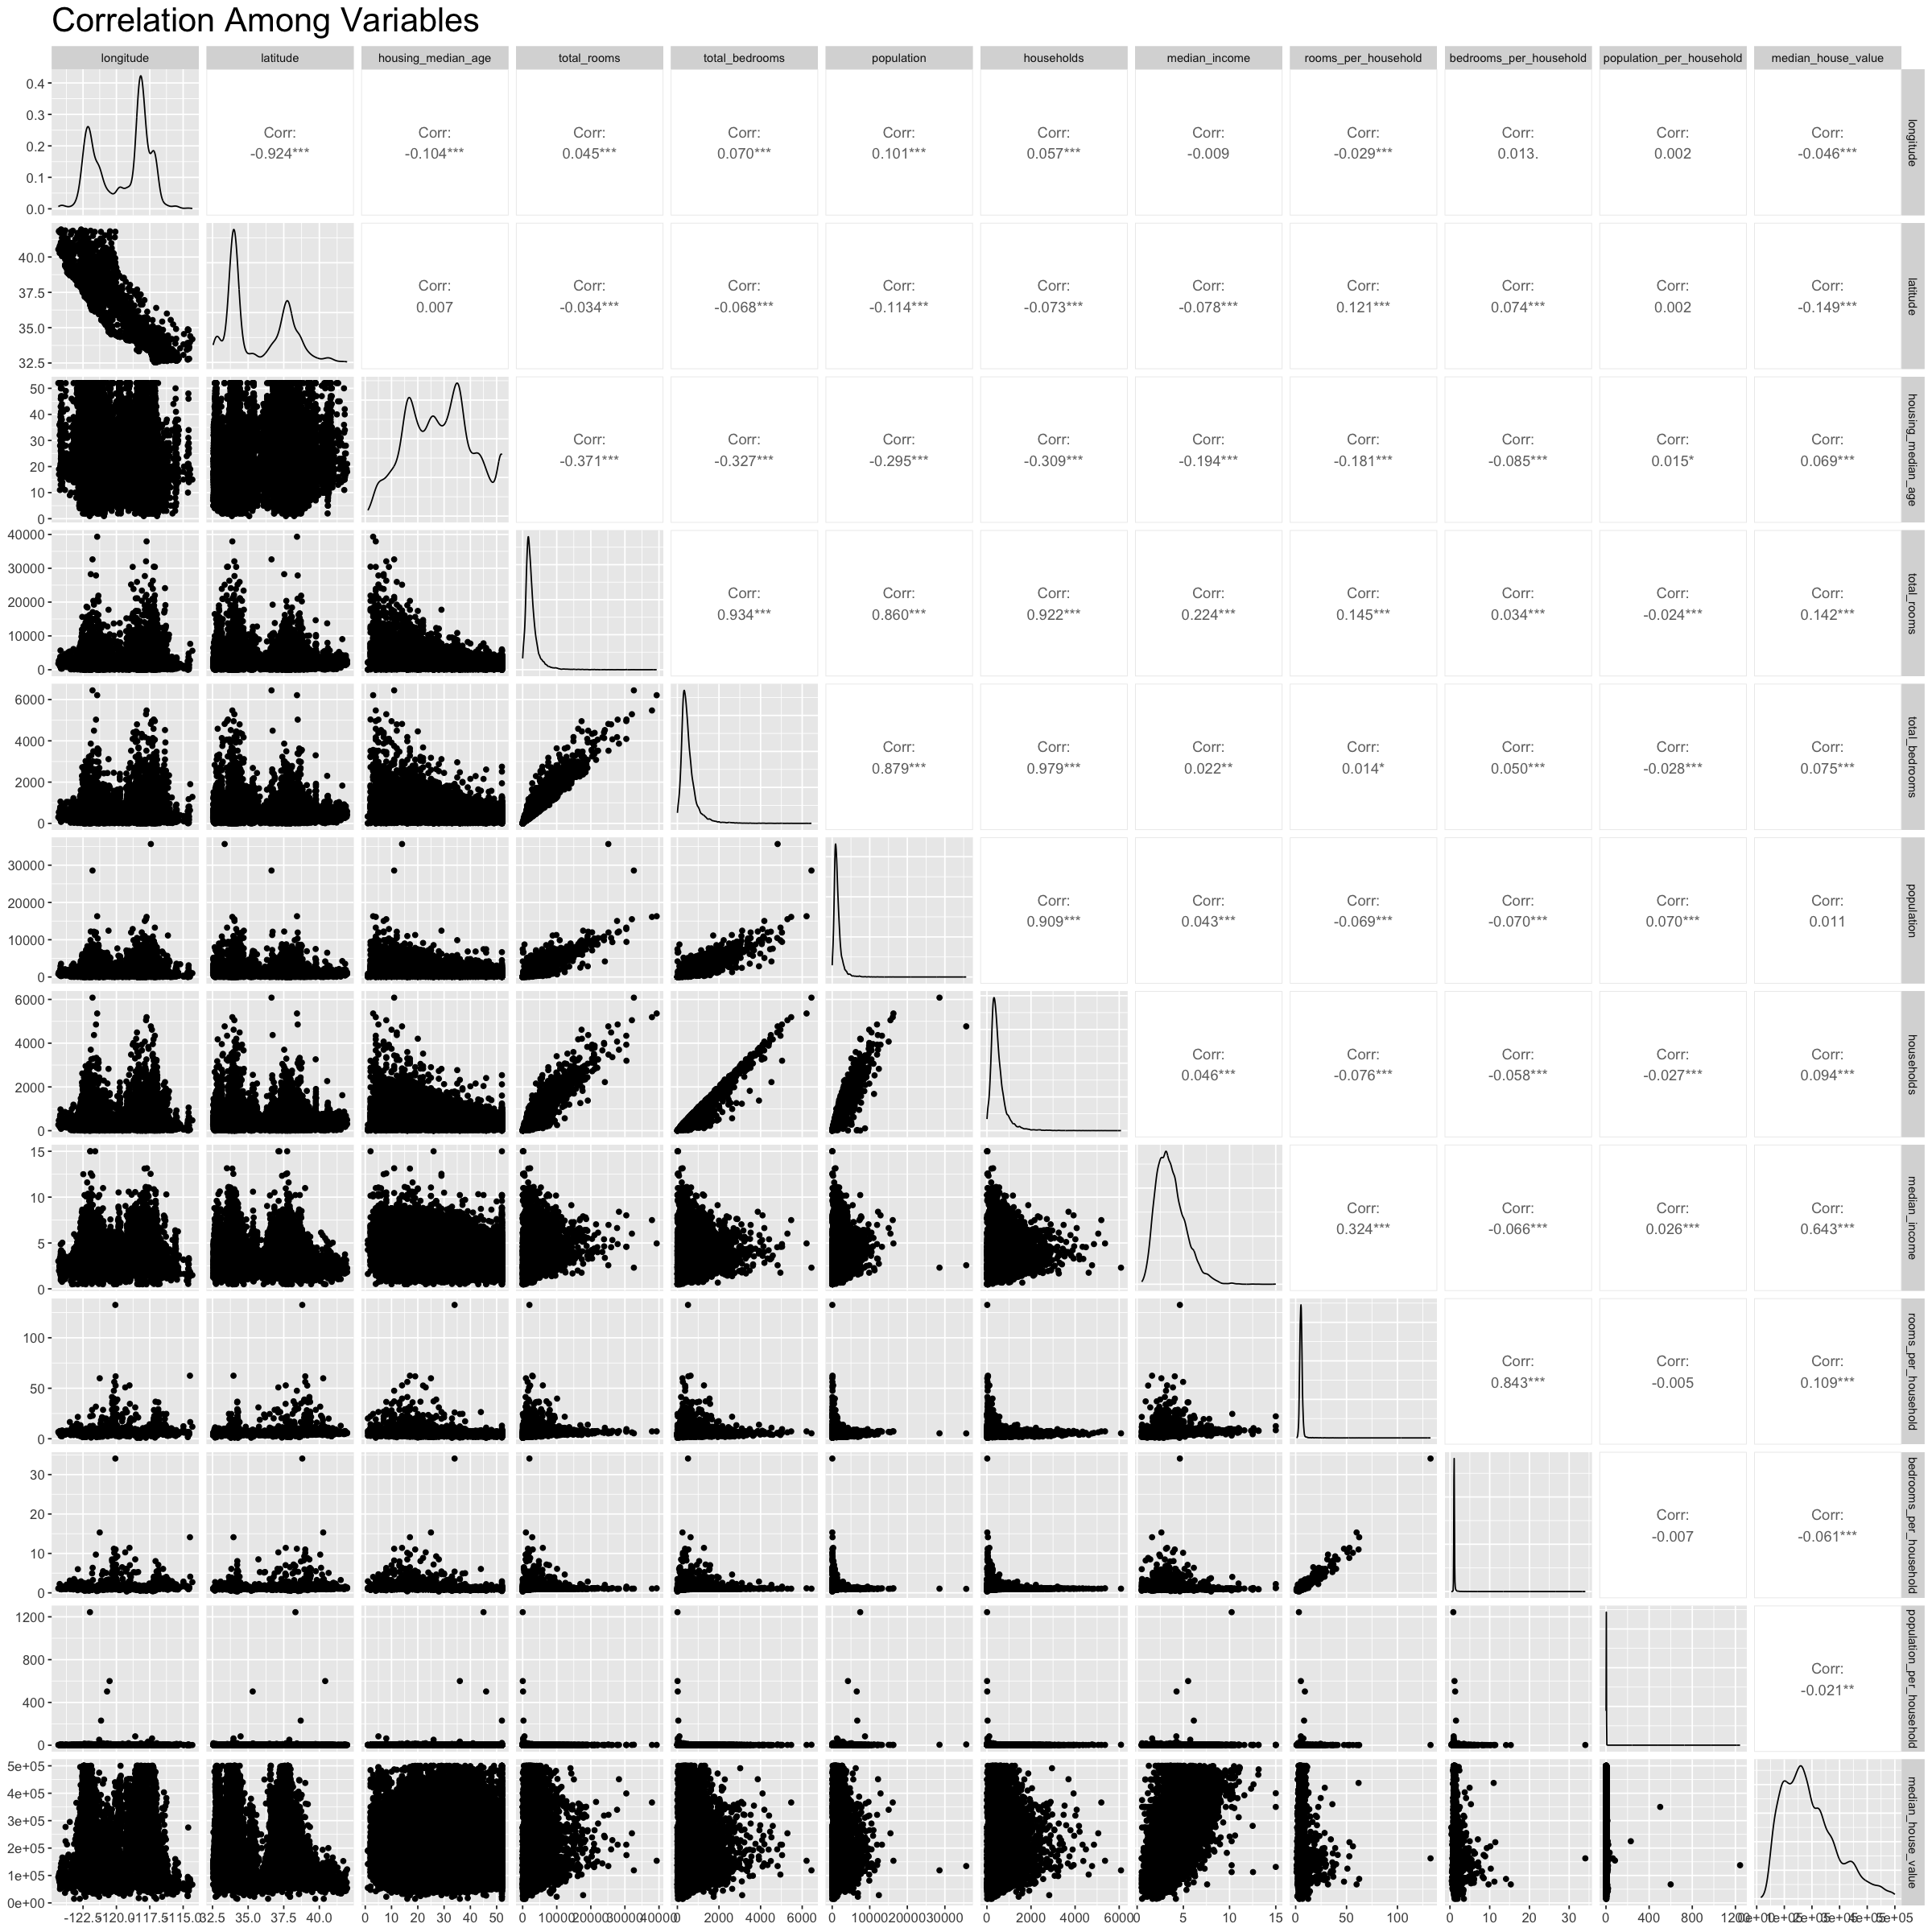

In [9]:
options(repr.plot.width=20, repr.plot.height=20)
data_pairs <- data %>% select(!"ocean_proximity")
ggpairs(data_pairs, title = "Correlation Among Variables") + 
    theme(axis.text = element_text(size = 10),
         plot.title = element_text(size = 25))

*Figure 4*

Upon initial inspection, `median_income` has the biggest correlation with `median_house_value`. People who earn more money tend to be able to afford more expensive houses. Additionally, we can see that many (potential) input variables are correlated with each other (such as `households` and `total_bedrooms` with a correlation coefficient of 0.979). We will take this into consideration when generating a model.

## Methods and Analysis

#### Fitting a full linear model and checking model assumptions

In [10]:
full_model <- lm(median_house_value ~ ., data = data)
tidy(full_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-2.135348e+06,7.963407e+04,-26.8145088,1.457240e-155
longitude,-2.481880e+04,9.224346e+02,-26.9057515,1.367098e-156
latitude,-2.287715e+04,9.100977e+02,-25.1370281,3.017467e-137
housing_median_age,9.350680e+02,4.065238e+01,23.0015535,1.559040e-115
total_rooms,-4.402280e+00,8.822843e-01,-4.9896384,6.101406e-07
total_bedrooms,5.842078e+01,7.198487e+00,8.1157022,5.114606e-16
population,-3.102517e+01,1.003178e+00,-30.9268940,4.669368e-205
households,6.611850e+01,7.592206e+00,8.7087338,3.314333e-18
median_income,3.994433e+04,4.632457e+02,86.2270860,0.000000e+00


*Table 5*

We then check for multicolinearity and drop columns that are highly correlated.

In [11]:
vif(full_model)

,GVIF,Df,GVIF^(1/(2*Df))
longitude,18.121550,1,4.256941
latitude,20.263380,1,4.501486
housing_median_age,1.369675,1,1.170331
total_rooms,19.663157,1,4.434316
total_bedrooms,48.923245,1,6.994515
population,6.973787,1,2.640793
households,44.787760,1,6.692366
median_income,2.796225,1,1.672192
ocean_proximity,4.122780,4,1.193710
rooms_per_household,12.230955,1,3.497278


*Table 6*

As seen in the table, `longitude`, `latitude`, `total_rooms`, `total_bedrooms`, and `households` has the highest GVIF value indication high correlations between these variables and other variables. We will drop these variables to try to solve this problem.

In [12]:
data_reduced  <- data %>% select(-longitude, -latitude, -total_rooms, -total_bedrooms, -households)

In [13]:
reduced_model  <- lm(median_house_value ~ ., data = data_reduced)
vif(reduced_model)

,GVIF,Df,GVIF^(1/(2*Df))
housing_median_age,1.321175,1,1.149424
population,1.132484,1,1.064183
median_income,2.592677,1,1.610179
ocean_proximity,1.457830,4,1.048246
rooms_per_household,8.354597,1,2.890432
bedrooms_per_household,7.041392,1,2.653562
population_per_household,1.010073,1,1.005024


*Table 7*

With low multicolinearity (GVIF < 10) in our columns, we are now ready to train inference models on our data.

Next, we want to check whether the normalilty assumption is broken. We do this by using the `plot()` function on our reduced model.

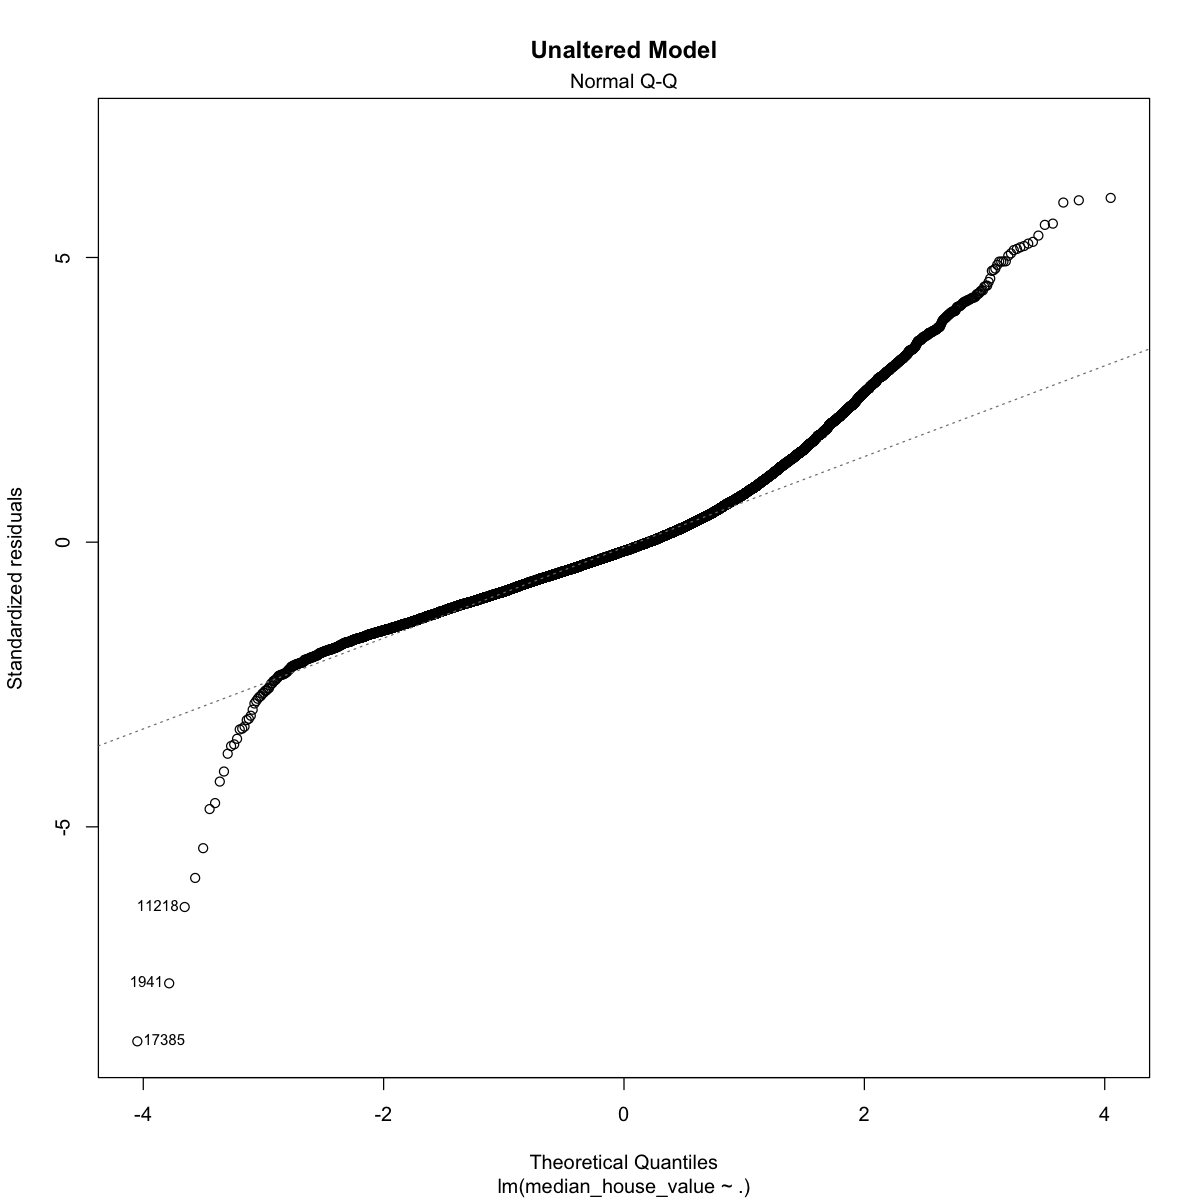

In [14]:
options(repr.plot.width=10, repr.plot.height=10)
plot(reduced_model, which = 2, main = "Unaltered Model")

*Figure 5*

The plots above show an odd pattern that doesn't stick to the dotted line, leading us to suspect that the normality assumption has been broken. To address this issue, we will take use natural logarithm of the response variable when the builing model. Below are plots that compare the two models and show us the result of transforming the response variable.

Model,RSQ
<chr>,<dbl>
Unaltered Model,0.5699025
Log Model,0.6108703


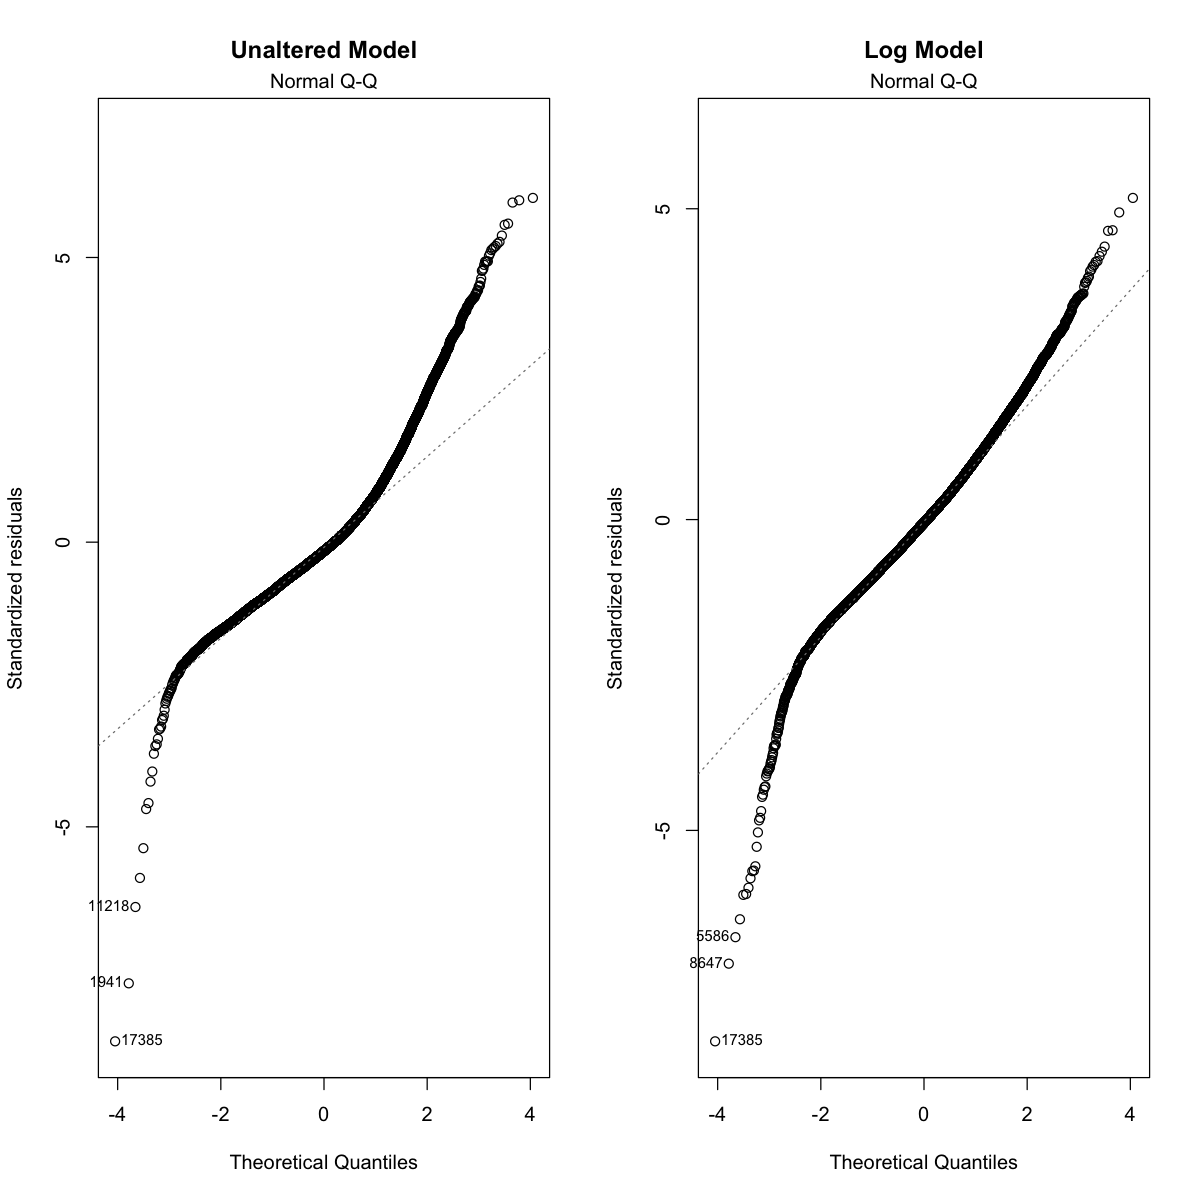

In [15]:
reduced_model_log  <- lm(log(median_house_value) ~ ., data = data_reduced)

rsq_comparison <- tibble(
    Model = c("Unaltered Model", "Log Model"),
    RSQ = c(summary(reduced_model)$adj.r.squared, summary(reduced_model_log)$adj.r.squared)
)
rsq_comparison
par(mfrow=c(1,2))
plot(reduced_model, which = 2, main = "Unaltered Model")
plot(reduced_model_log, which = 2, main = "Log Model")

*Table 8 and Figure 6*

From the table, we can see that the transformed model (taking the natural log of the response) better explains the data and results in a better fitting Q-Q plot. Because of this, we will transform the response variable in our final model as well.

## Creating generative models

To avoid bias, we will first split our data into two evenly divided portions -- one for variable selection, and the other for fitting the inference model. We will name the two portions `data_selection` and `data_inference`.

In [16]:
set.seed(1234)
indices <- sample.int(nrow(data_reduced), nrow(data_reduced) / 2)
data_selection <- data_reduced[indices, ]
data_inference <- data_reduced[-indices, ]

### Using stepwise algorithms to select a generative model

Rather than arbitrarily using the full model, we would like to select particular variables to form a better model. In this section, automated procedures will be conducted to select the best model. The two most common methods will be used, which are Forward and Backward algorithms.

First, we will use Forward selection. We will use the dataset `data_selection` to perform the selection algorithm. A summary of the Forward selection result is generated as follows.

In [17]:
housing_forward_sel <- regsubsets(
    x = median_house_value ~ ., nvmax=10,
    data = data_selection, 
    method = "forward")
housing_forward_summary <- summary(housing_forward_sel)
housing_forward_summary$which

,(Intercept),housing_median_age,population,median_income,ocean_proximityINLAND,ocean_proximityISLAND,ocean_proximityNEAR BAY,ocean_proximityNEAR OCEAN,rooms_per_household,bedrooms_per_household,population_per_household
1,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
2,TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
3,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
4,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE
5,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE
6,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,FALSE
7,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,FALSE
8,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE
9,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
10,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


*Table 9*

To have a more intuitive result, as well as obtain the corresponding statistics of each number of selected variables, a summary table is generated, which is useful to decide the number of variables in the best model. For the generative model, we will refer to adjusted $R^2$. To be specific, the `n_input_variables` with the largest adjusted $R^2$ value will be selected. A plot is also generated for a better view and understanding.

In [18]:
housing_forward_summary_df <- tibble(
    n_input_variables = 1:10,
    RSQ = housing_forward_summary$rsq,
    RSS = housing_forward_summary$rss,
    ADJR2 = housing_forward_summary$adjr2,
    Cp = housing_forward_summary$cp,
    BIC = housing_forward_summary$bic)
housing_forward_summary_df

n_input_variables,RSQ,RSS,ADJR2,Cp,BIC
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.4172163,5.440792e+13,0.4171564,3713.00042,-5239.020
2,0.5519656,4.182790e+13,0.5518735,606.06068,-7790.143
3,0.5608943,4.099433e+13,0.5607589,402.05828,-7976.963
4,0.5638199,4.072120e+13,0.5636406,336.55845,-8032.870
5,0.5654236,4.057148e+13,0.5652003,301.55816,-8059.552
6,0.5668545,4.043789e+13,0.5665874,270.54351,-8082.483
7,0.5754927,3.963144e+13,0.5751873,73.24284,-8269.446
8,0.5769764,3.949293e+13,0.5766285,41.01170,-8294.353
9,0.5782380,3.937515e+13,0.5778477,13.90340,-8314.252


*Table 10*

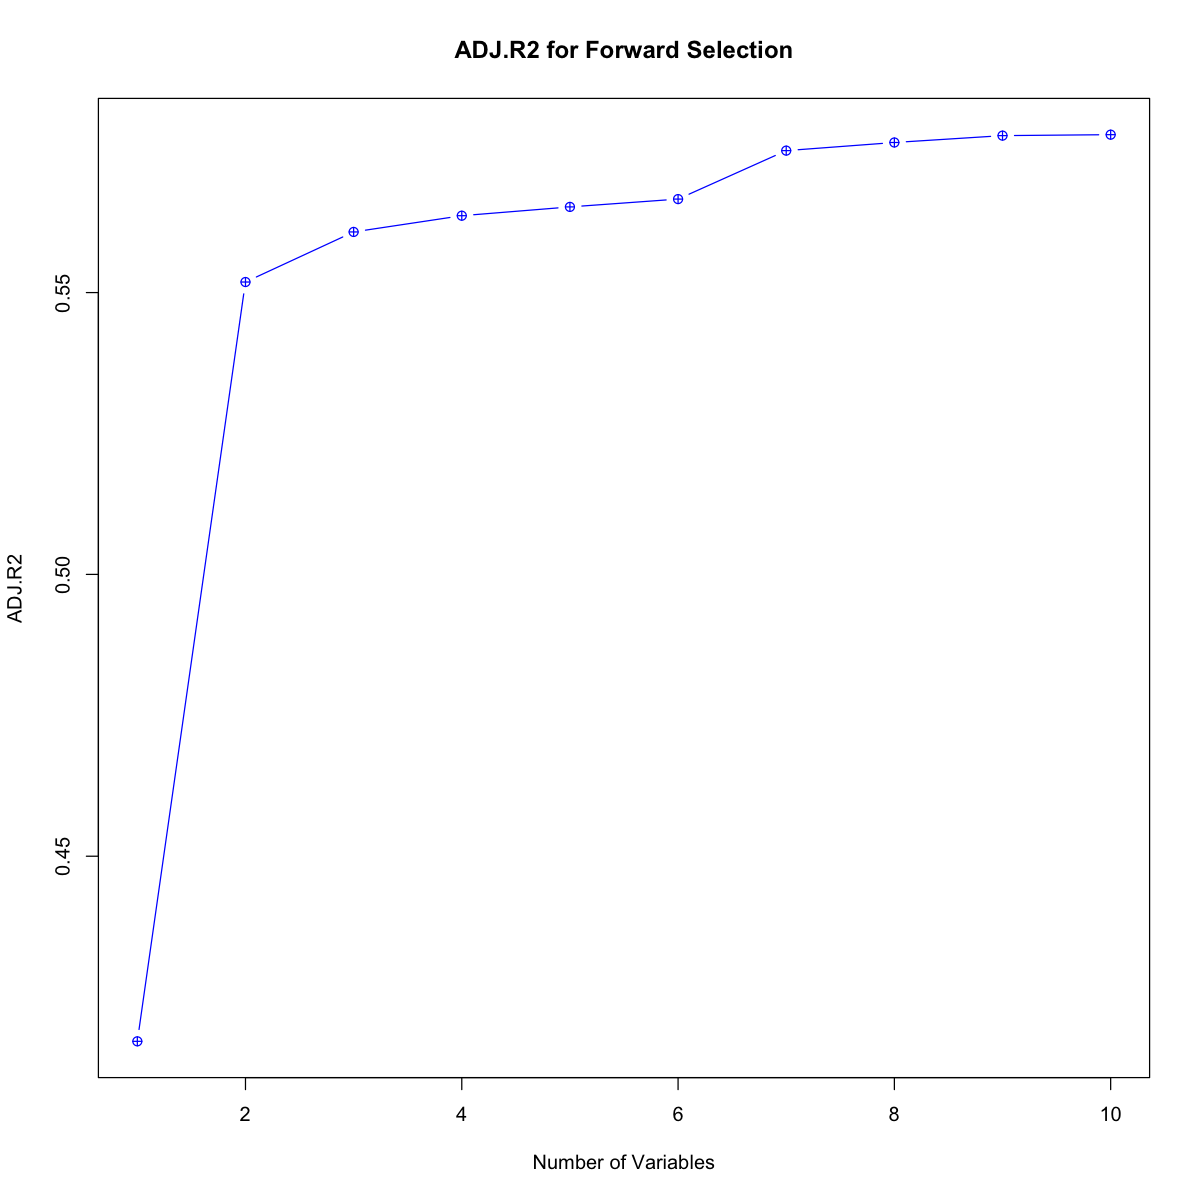

In [19]:
plot(summary(housing_forward_sel)$adjr2,
    main = "ADJ.R2 for Forward Selection", xlab = "Number of Variables", ylab="ADJ.R2",
    type = "b", pch = 10, col="blue")

*Figure 7*

As the results show, the best model contains all 10 variables based on Forward selection. The corresponding adjusted $R^2$ value is 0.5780, which is the largest among all the possible $n$.

To ensure the correctness and validation of our selection, the Backward Algorithm will also be performed. We will still use the dataset `data_selection`. The summary of the selection as well as the table with all the possible number of variables and the corresponding statistics will be generated.

In [20]:
housing_backward_sel <- regsubsets(
    x = median_house_value ~ ., nvmax=10,
    data = data_selection, 
    method="backward",
)
housing_backward_summary <- summary(housing_backward_sel)
housing_backward_summary$which

,(Intercept),housing_median_age,population,median_income,ocean_proximityINLAND,ocean_proximityISLAND,ocean_proximityNEAR BAY,ocean_proximityNEAR OCEAN,rooms_per_household,bedrooms_per_household,population_per_household
1,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
2,TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
3,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
4,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE
5,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE
6,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE,FALSE
7,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE
8,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE
9,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
10,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


*Table 11*

In [21]:
housing_backward_summary_df <- tibble(
    n_input_variables = 1:10,
    RSQ = housing_backward_summary$rsq,
    RSS = housing_backward_summary$rss,
    ADJR2 = housing_backward_summary$adjr2,
    Cp = housing_backward_summary$cp,
    BIC = housing_backward_summary$bic)
housing_backward_summary_df

n_input_variables,RSQ,RSS,ADJR2,Cp,BIC
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.4172163,5.440792e+13,0.4171564,3713.00042,-5239.020
2,0.5519656,4.182790e+13,0.5518735,606.06068,-7790.143
3,0.5608943,4.099433e+13,0.5607589,402.05828,-7976.963
4,0.5624675,4.084746e+13,0.5622877,367.76060,-8002.727
5,0.5709011,4.006011e+13,0.5706806,175.18053,-8183.060
6,0.5740997,3.976149e+13,0.5738370,103.38263,-8246.730
7,0.5755874,3.962260e+13,0.5752821,71.05724,-8271.619
8,0.5769764,3.949293e+13,0.5766285,41.01170,-8294.353
9,0.5782380,3.937515e+13,0.5778477,13.90340,-8314.252


*Table 12*

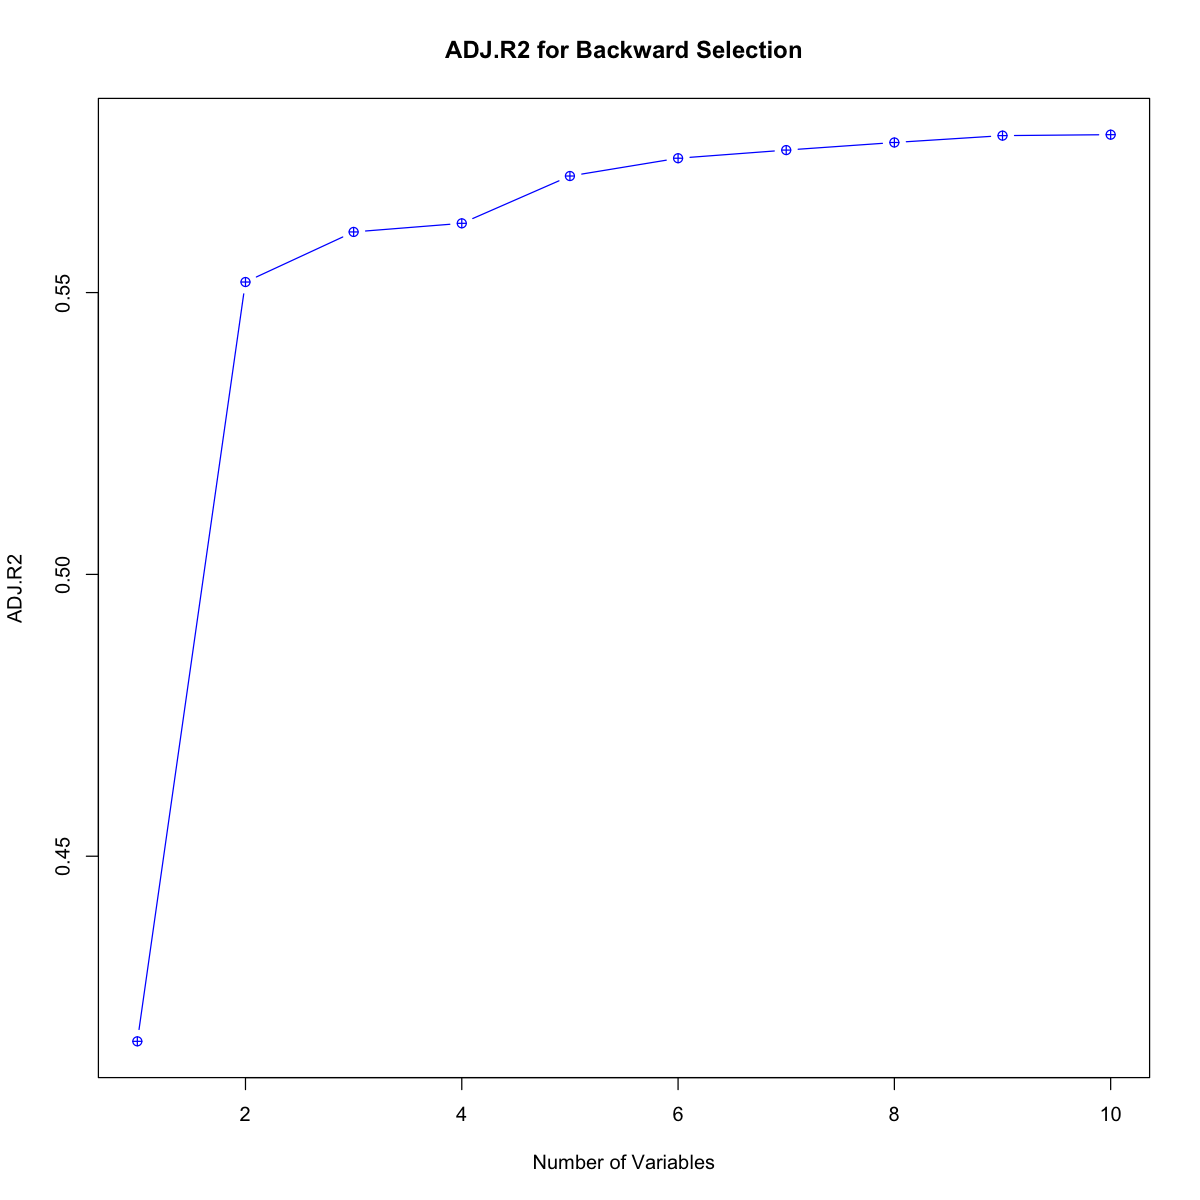

In [22]:
plot(summary(housing_backward_sel)$adjr2,
    main = "ADJ.R2 for Backward Selection", xlab = "Number of Variables", ylab="ADJ.R2",
    type = "b", pch = 10, col="blue")

*Figure 8*

From the results above, it is clear that the number of selective variables is also 10, with the same adjusted $R^2$, 0.5780. With that being said, our model should contain the following explanatory variables: `housing_median_age`, `population`, `median_income`, `ocean_proximity`, `rooms_per_household`, `bedrooms_per_household`, and `population_per_household`.

### Using LASSO to select a generative model

Apart from using forward/backward selection to create a model, we would like to see if LASSO generates a model with different parameters. Simutaneously, we would like to explore whether LASSO yields a better or worse performing model. 

We will choose our LASSO with a $\lambda$ value that gives the smallest $MSE_{test}$.

In the following cell, we create the X and Y portion of the variable selection portion. Because we have a categorical variable, `ocean_promixity`, we need to create group dummy variables in order to fit a LASSO model. The code to do so is referenced [here](https://stackoverflow.com/questions/46865838/using-lasso-in-r-with-categorical-variables). 

In [23]:
set.seed(1234)

data_selection <- data_selection %>% mutate(ocean_proximity = as.factor(ocean_proximity))
data_selection_Y <- data_selection %>% select(median_house_value) %>% as.matrix()

vars_name <- data_selection %>% 
  select(-median_house_value) %>% 
  colnames() %>%
  str_c(collapse = "+")

model_string <- paste("median_house_value  ~", vars_name)

data_selection_X <- model.matrix(as.formula(model_string), data_selection)

Then, we train the regression using LASSO and find the optimal value of the hyperparameter $\lambda$.

The best lambda value is 148.4132

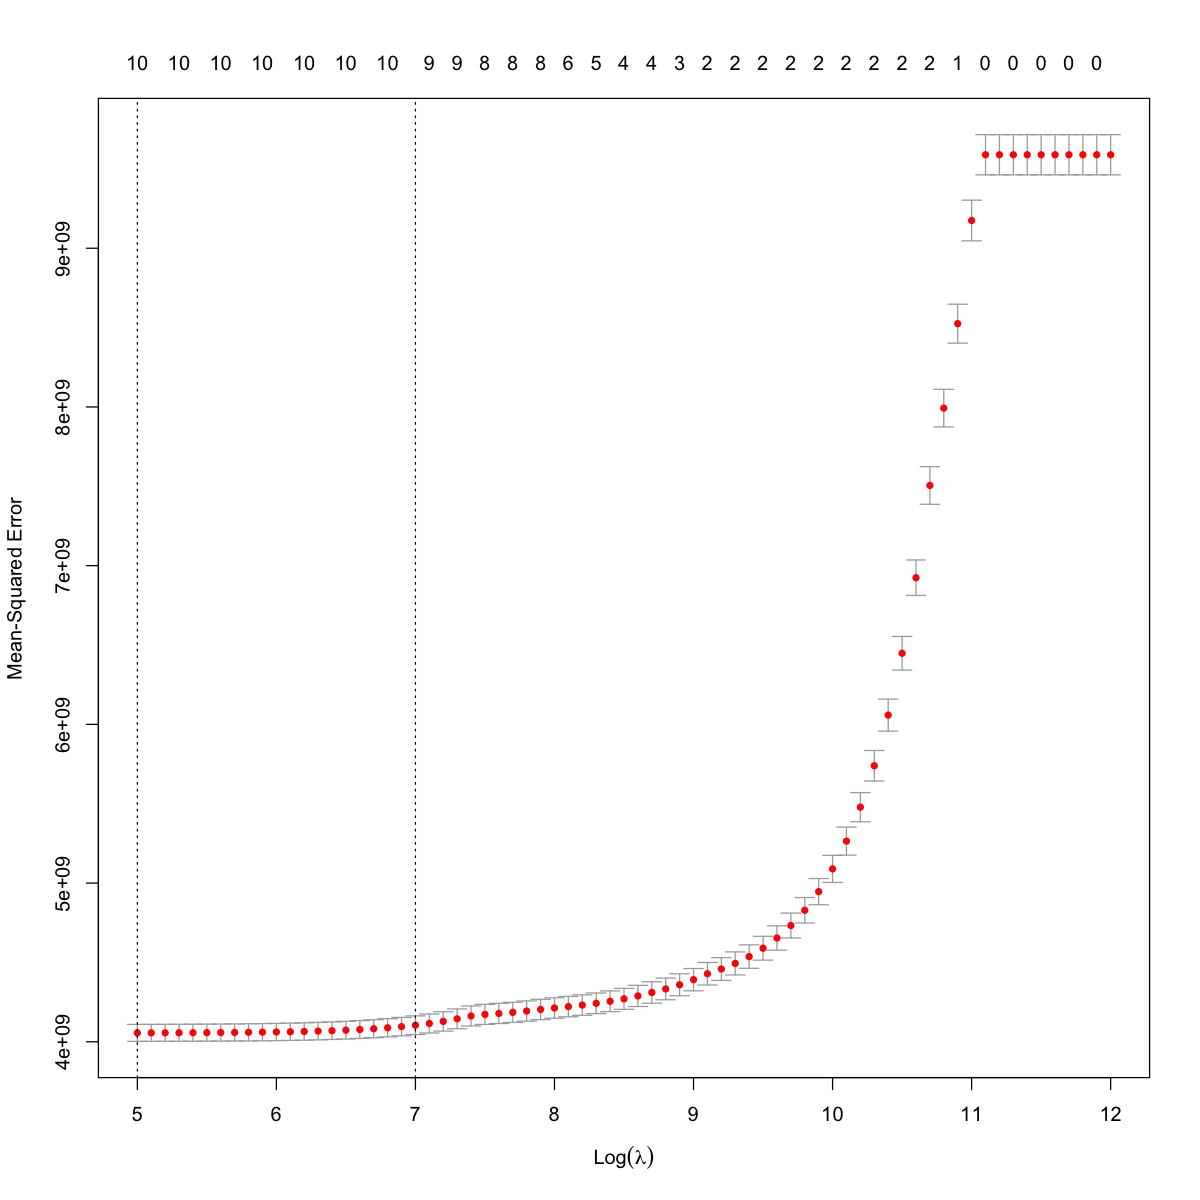

In [24]:
set.seed(1234)

# referenced from worksheet 11
housing_lambda_LASSO <- cv.glmnet(
  x = data_selection_X, y = data_selection_Y,
  alpha = 1,
  lambda = exp(seq(5, 12, 0.1))
)

housing_lambda_min_MSE_LASSO <- round(housing_lambda_LASSO$lambda.min, 4)
cat("The best lambda value is", housing_lambda_min_MSE_LASSO)
plot(housing_lambda_LASSO)

*Figure 9*

Now, we train another LASSO model using the optimal lambda we found.

In [25]:
housing_LASSO_min <- glmnet(
  x = data_selection_X, y = data_selection_Y,
  alpha = 1,
  lambda = housing_lambda_min_MSE_LASSO
)

In [26]:
housing_LASSO_min$beta

11 x 1 sparse Matrix of class "dgCMatrix"
                                     s0
(Intercept)                    .       
housing_median_age           844.826139
population                     1.167627
median_income              43989.688939
ocean_proximityINLAND     -58256.574812
ocean_proximityISLAND     249343.388794
ocean_proximityNEAR BAY    11831.085576
ocean_proximityNEAR OCEAN  19598.523380
rooms_per_household       -11014.762506
bedrooms_per_household     59986.903004
population_per_household    -264.769093

To our surprise, LASSO selected the exact same model as stepwise selection. The model also consists of all 10 parameters, which are `housing_median_age`, `population`, `median_income`, `ocean_proximity`, `rooms_per_household`, `bedrooms_per_household`, and `population_per_household`.

## Inference

To avoid post-inference/post-lasso problems, we will use the second split of data(`data_inference`) to fit a least squares (LS) regression on the variables selected by both selection methods. Lasso is a biased estimator so we can't rely on the coefficients generated by this method. As indicated previously, we will transform the response variable by using `log(median_house_value)` in the model.

In [27]:
inference_model <- lm(log(median_house_value) ~ ., 
                      data = data_inference)
summary(inference_model)


Call:
lm(formula = log(median_house_value) ~ ., data = data_inference)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.72536 -0.21979 -0.01804  0.20438  1.70026 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                1.132e+01  2.020e-02 560.620  < 2e-16 ***
housing_median_age         2.515e-03  3.102e-04   8.105 5.89e-16 ***
population                 1.137e-05  3.100e-06   3.667 0.000246 ***
median_income              2.094e-01  3.417e-03  61.268  < 2e-16 ***
ocean_proximityINLAND     -4.494e-01  8.997e-03 -49.948  < 2e-16 ***
ocean_proximityISLAND      5.947e-01  1.933e-01   3.076 0.002103 ** 
ocean_proximityNEAR BAY    2.902e-02  1.170e-02   2.480 0.013173 *  
ocean_proximityNEAR OCEAN  3.742e-02  1.093e-02   3.422 0.000624 ***
rooms_per_household       -3.471e-02  4.138e-03  -8.386  < 2e-16 ***
bedrooms_per_household     1.748e-01  1.855e-02   9.423  < 2e-16 ***
population_per_household  -3.724e-03  5.513e-04  -

In [28]:
tidy(inference_model) %>% mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),11.325,0.020,560.620,0.000
housing_median_age,0.003,0.000,8.105,0.000
population,0.000,0.000,3.667,0.000
median_income,0.209,0.003,61.268,0.000
ocean_proximityINLAND,-0.449,0.009,-49.948,0.000
ocean_proximityISLAND,0.595,0.193,3.076,0.002
ocean_proximityNEAR BAY,0.029,0.012,2.480,0.013
ocean_proximityNEAR OCEAN,0.037,0.011,3.422,0.001
rooms_per_household,-0.035,0.004,-8.386,0.000


*Table 13*

Our final model is: 
$$ln(Y) = 11.325 + 0.003 x_1 + 0.00001 x_2 + 0.209 x_3 -0.449 x_4 + 0.595 x_5 + 0.029 x_6 + 0.037 x_7 -0.035x_8 +0.175 x_9 - 0.004 x_{10}$$

where
- $x_1$ = `housing_median_age`
- $x_2$ = `population` 
- $x_3$ = `median_income`
- $x_4$ = `ocean_proximityINLAND`
- $x_5$ = `ocean_proximityISLAND`
- $x_6$ = `ocean_proximityNEAR BAY`
- $x_7$ = `ocean_proximityNEAR OCEAN`
- $x_8$ = `rooms_per_household` 
- $x_9$ = `bedrooms_per_household`
- $x_{10}$ = `population_per_household`

The most notable effects on the median house value in this model is median income considering that income isn't extremely limited in the maximum value it can have. This makes sense considering that people with larger incomes tend to be able to afford more expensive houses. The age of a house also increases the value of the house, but it's not by a significant margin. For ocean proximity, there seems to be a trend that the closer you are to water, the more valuable your house may tend to be. Being an inland district results in a substantial decrease to the median house value, holding all other variables constant. For the average per households, population and rooms seem to decrease the value of a house while bedrooms increase the value.

It is important to note that this is a log-linear model. The interpretation of each coefficient $\hat{\beta}_i$ is that a 1 unit increase in the predictor multiplies the expected value of Y by $e^{\hat{\beta}_i}$.

All the p-values are below 0.05 (the significance level), and so all the predictors are significantly associated with the median house value of a district. Therefore, we can reject the null hypothesis.

## Discussion

Through our analysis, we were able to select variables and build a generative model that describes the association between several house and district characteristics with the district’s median house value. However, the dataset had several issues that we had to deal with prior to conducting any analysis, including multicollinearity (as shown during our preliminary inspection), data censorship, and broken normality assumptions within the dataset. After addressing those issues, we were able to start selecting variables. What was most surprising to us is that both the forward/backward and lasso variable selection methods resulted in the selection of all 10 variables. We were planning to fit our second split of data into both the forward/backward selected model and the lasso selected model and then use the F-test to compare models but this was not necessary. Once we fitted the data, we found that all the selected predictors were significantly associated with the response variable and our model has a $R^2$ value of 0.6038, meaning that ~61% of the data was explained by the model. A summary of the findings can be seen above. Again, it is important to note that the model is a log-linear model. 

One way to improve this model is by not omitting the censored data points and attempting to fit a Tobit model instead. This would account for all the data and perhaps return different results than we found. Because we omitted those values, our model was limited to median house values of $500000, inferring on districts with equal or less median house values. Although this additive model was generated to help better understand the relationship of house/district factors and median house values, we could expand upon it by checking for interaction terms and perhaps use it for predictive purposes.

## References

Géron, A. (2017). Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems, 1st Edition. https://github.com/ageron/handson-ml/tree/master/datasets/housing

Kelley Pace, R., & Barry, R. (1997). Sparse spatial autoregressions. Statistics & Probability Letters, 33(3), 291–297. https://doi.org/10.1016/s0167-7152(96)00140-x 

Stadelmann, D. (2010). Which factors capitalize into house prices? A Bayesian averaging approach. Journal of Housing Economics, 19(3), 180–204. https://doi.org/10.1016/j.jhe.2010.07.002 
